In [1]:
#Reference/Code: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('./PoliceDataFull2021.csv')
#print ("data:", data)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



In [2]:
# Source:
# https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
# Toy example to see if plots work-

In [3]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt


%matplotlib inline

# Raw Data
heights = np.array([50,52,53,54,58,60,62,64,66,67,68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,45,45,50,75,95,65,50,40,45])


In [4]:
def setupformat(x, ax, plt, title, xlabel, ylabel):
    # Figure Modifications --------------------------------------------------------
    # Borders
    ax.spines["top"].set_color("0.5")
    ax.spines["bottom"].set_color("0.5")
    ax.spines["left"].set_color("0.5")
    ax.spines["right"].set_color("0.5")
    ax.get_xaxis().set_tick_params(direction="out")
    ax.get_yaxis().set_tick_params(direction="out")
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left() 

    # Labels
    plt.title(title, fontsize="14", fontweight="bold")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(np.min(x) - 1, np.max(x) + 1)

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    display = (0, 1)
    anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
    legend = plt.legend(
        [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
        [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
        loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
    )  
    frame = legend.get_frame().set_edgecolor("0.5")

    # Save Figure
    plt.tight_layout()
    #plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")

    #plt.show()

In [5]:
def poststats(x, y, ax, plt):

    #print ("DEBUG x.shape:", x.shape, "y.shape:", y.shape)
    slope, intercept = np.polyfit(np.array(x), np.array(y), 1)  # linear model adjustment

    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

    residual = y - y_model

    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # calculating the r2
    # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
    # Pearson's correlation coefficient
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2

    # mean squared error
    MSE = 1/n * np.sum( (y - y_model)**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = np.polyval([slope, intercept], x_line)

    # confidence interval
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    # predicting interval
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    """
    ############### Ploting
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure()
    ax = fig.add_axes([.1, .1, .8, .8])

    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    """

    # rounding and position must be changed for each case and preference
    a = str(np.round(intercept))
    b = str(np.round(slope,2))
    r2s = str(np.round(r2,2))
    MSEs = str(np.round(MSE))

    ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
    ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)

    plt.legend(bbox_to_anchor=(1, .25), fontsize=12)


In [6]:
def plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    #print ("DEBUG: x", x)
    #print ("DEBUG: x2", x2)
    #print ("DEBUG: y2", y2)
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")
    setupformat(x, ax, plt, title, xlabel, ylabel)
    poststats(x, y,ax,plt)
    return ax


def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    setupformat(ax, plt)
    poststats(x,y,ax,plt)
    return ax

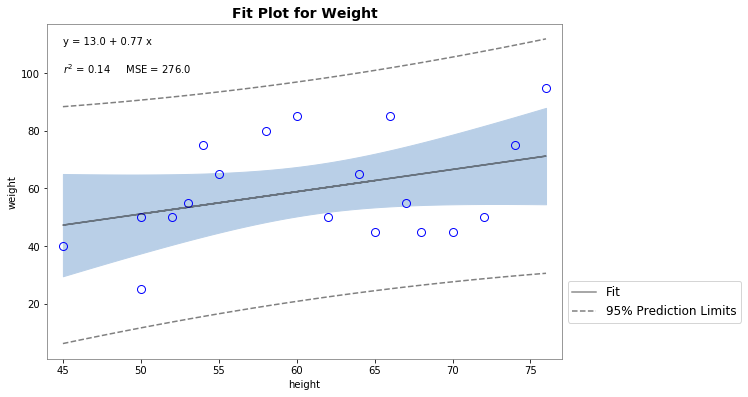

In [7]:
# Computations ----------------------------------------------------------------    
#x = heights
#y = weights
def plot(x, y, title, xlabel, ylabel):
    # Modeling with Numpy
    def equation(a, b):
        """Return a 1D polynomial."""
        return np.polyval(a, b) 

    p, cov = np.polyfit(np.array(x), np.array(y), 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = x.size                                                 # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    # Data
    ax.plot(
        x, y, "o", color="#b9cfe7", markersize=8, 
        markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
    )

    # Fit
    ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")

    # Confidence Interval (select one)
    plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=ax)
    #plot_ci_bootstrap(x, y, resid, ax=ax)

    plt.show()
plot(heights, weights, "Fit Plot for Weight", "height", "weight")

In [8]:
#Ok Actually plotting real data!!

In [9]:
print ("data:", data)

data:     GMA   EI  Con  EStab  Ext  Open  Agree  PerT  PerfJ  Gender 0=Female  \
0     2   79   58     77   28    25   44.0    30      5                1   
1     4   74   73     52   36    20   45.0    61      2                1   
2     8   88   71     67   75    55   18.0    74      6                0   
3     9   94   60     75   49     4   87.0    61      5                1   
4    10  106   43     76   52    27   50.0     5      8                1   
5    10   89   66     44   35    52   30.0    42      4                1   
6    10  101   52     67   53    56    8.6    26      6                1   
7    11   91   56     76   45    51   55.0    64      6                1   
8    11   51   67     36   55    47   53.0    93      6                1   
9    11  109   65     50   52    10    9.0    48      5                1   
10   12   71   53     49   55    25   25.0    31      4                1   
11   12  108   53     71   64    38   74.0    58      4                1   
12   1

In [10]:
data['EI']

0      79
1      74
2      88
3      94
4     106
5      89
6     101
7      91
8      51
9     109
10     71
11    108
12    111
13     58
14     95
15     98
16     87
17    104
18    129
19     99
20     91
21     86
22    121
23     80
24    103
25    116
26    137
27     87
28    104
29     87
     ... 
42    115
43     95
44    124
45     56
46     69
47    123
48     78
49    131
50    112
51     92
52    147
53    104
54     88
55    117
56     91
57    113
58    135
59    134
60    113
61    137
62    125
63    109
64    141
65    152
66    154
67     83
68    140
69    128
70    120
71    110
Name: EI, Length: 72, dtype: int64

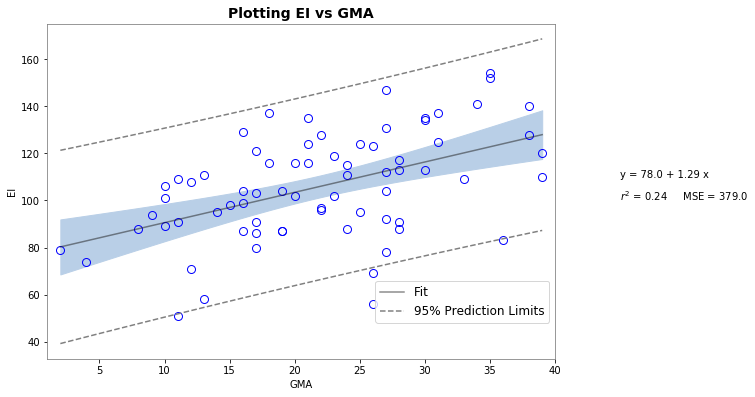

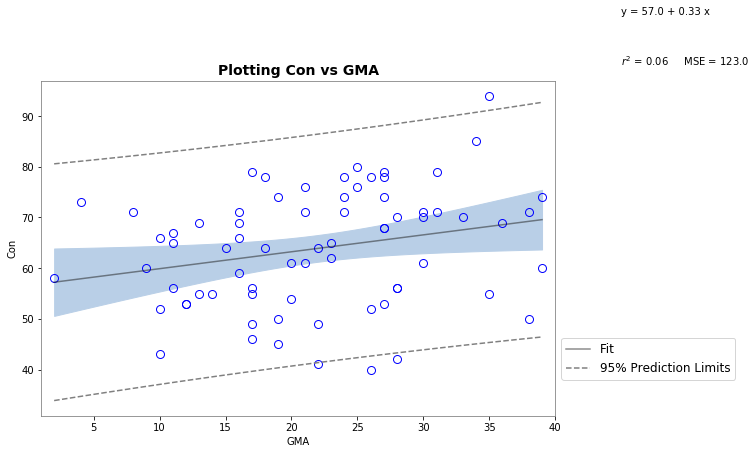

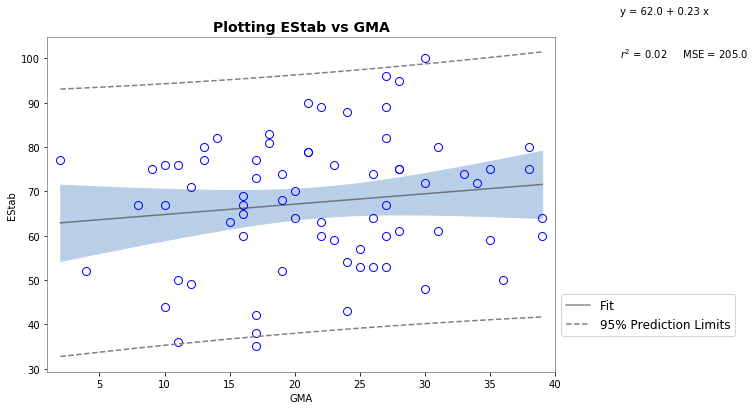

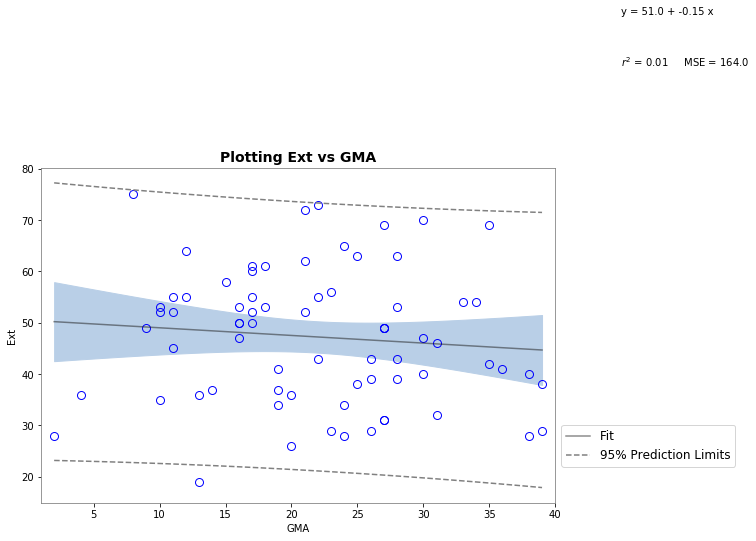

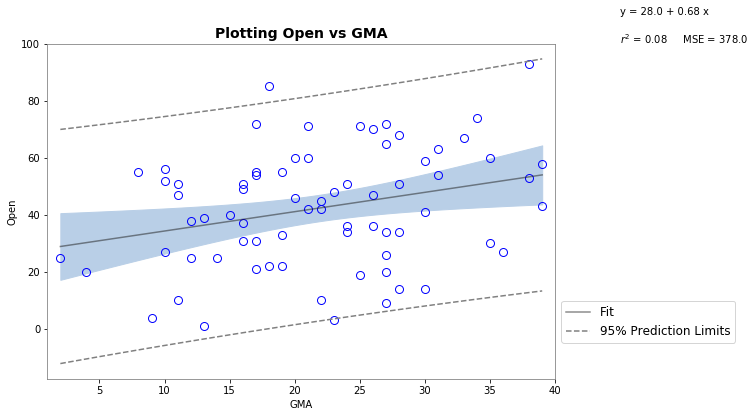

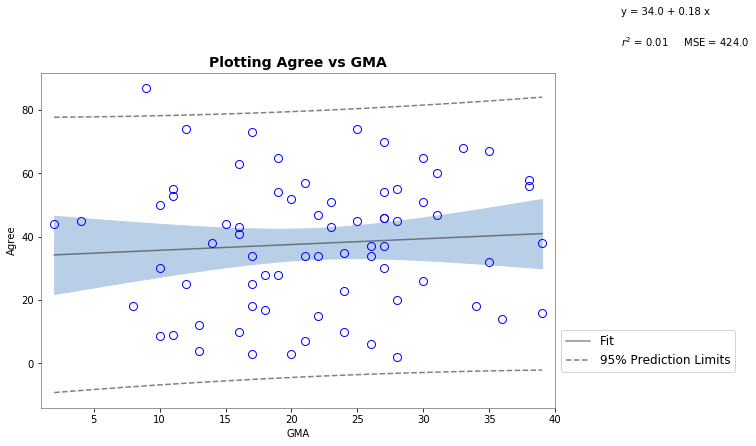

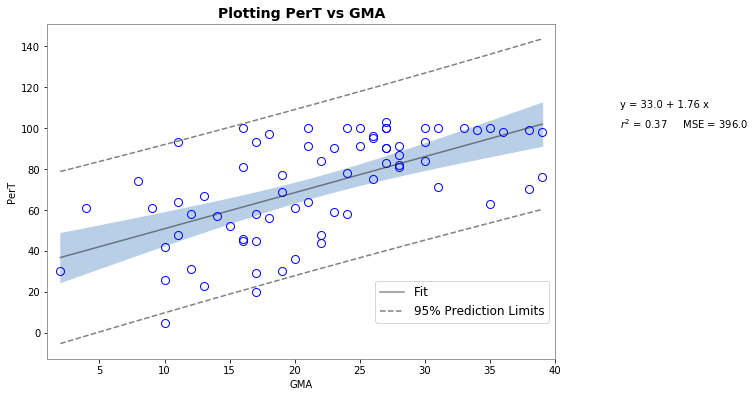

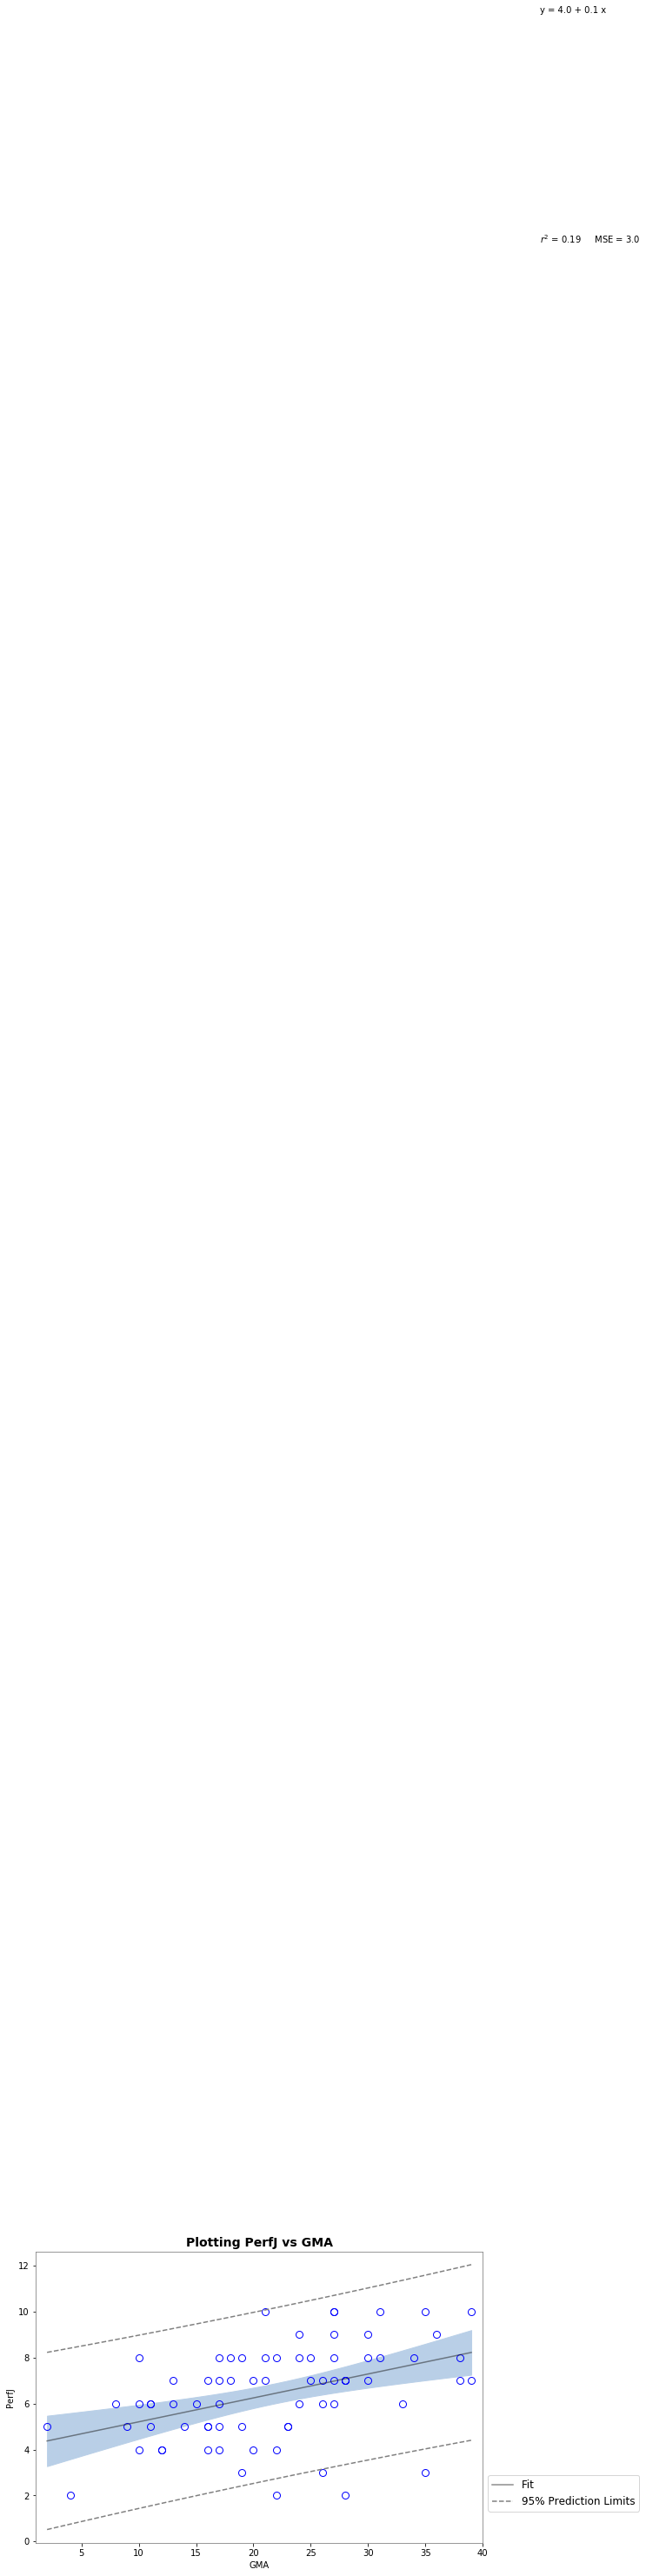

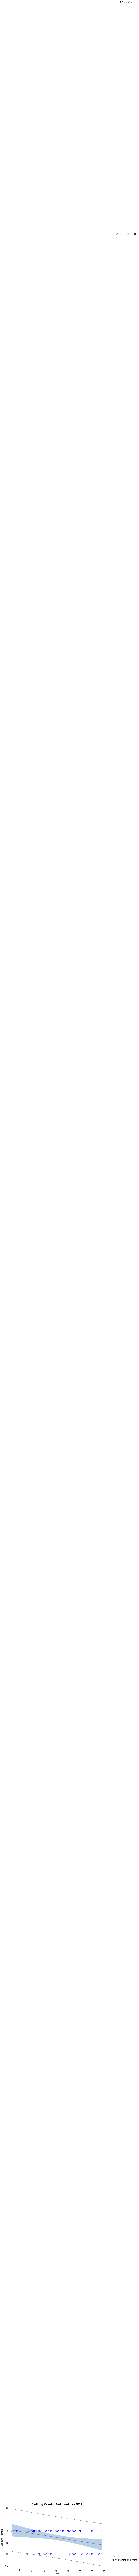

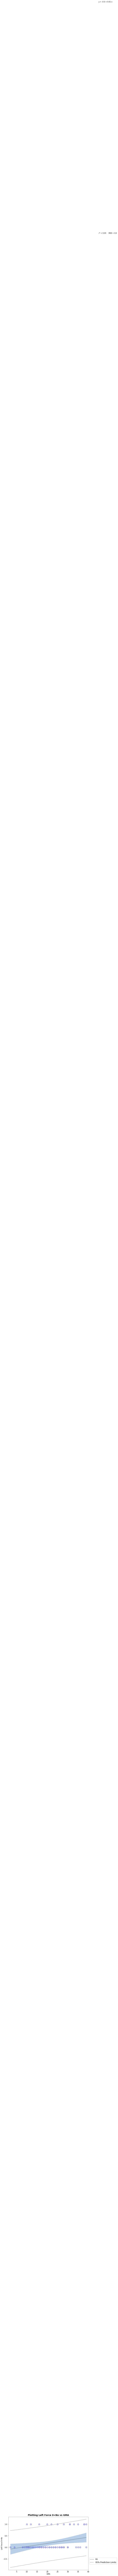

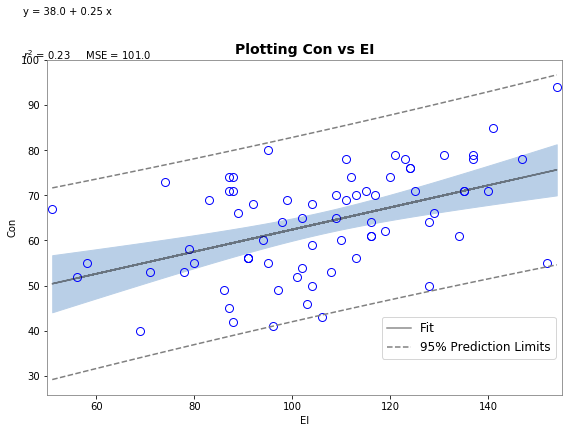

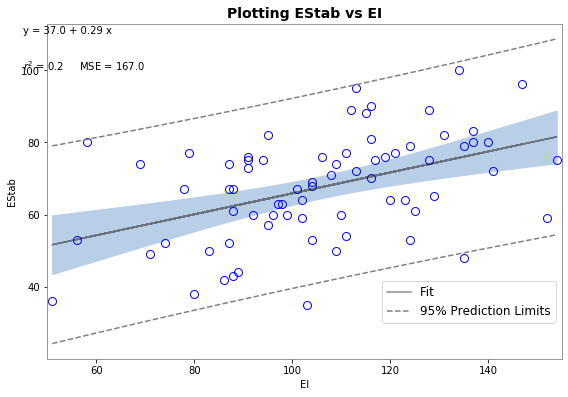

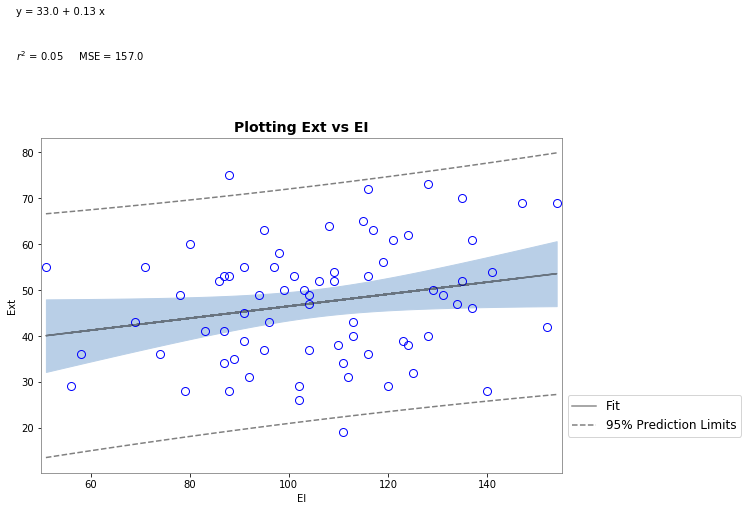

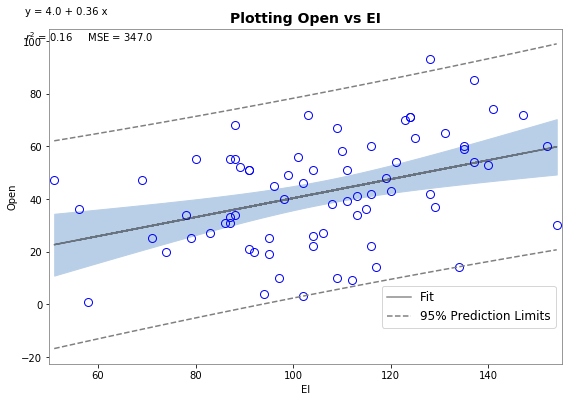

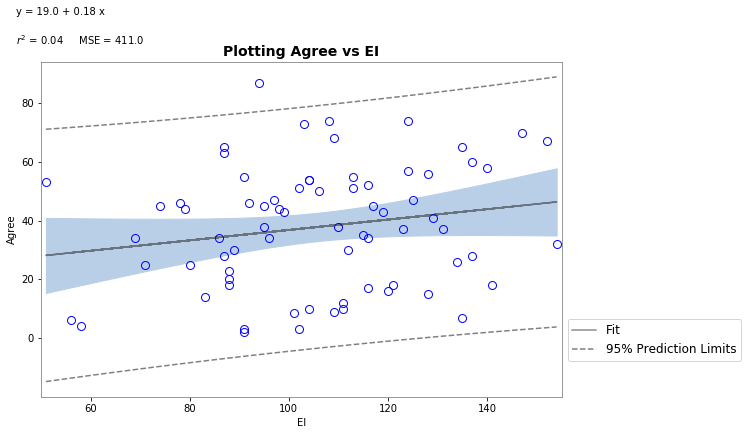

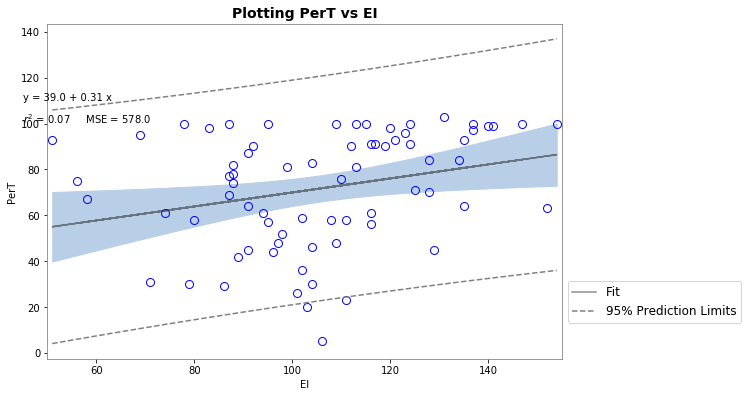

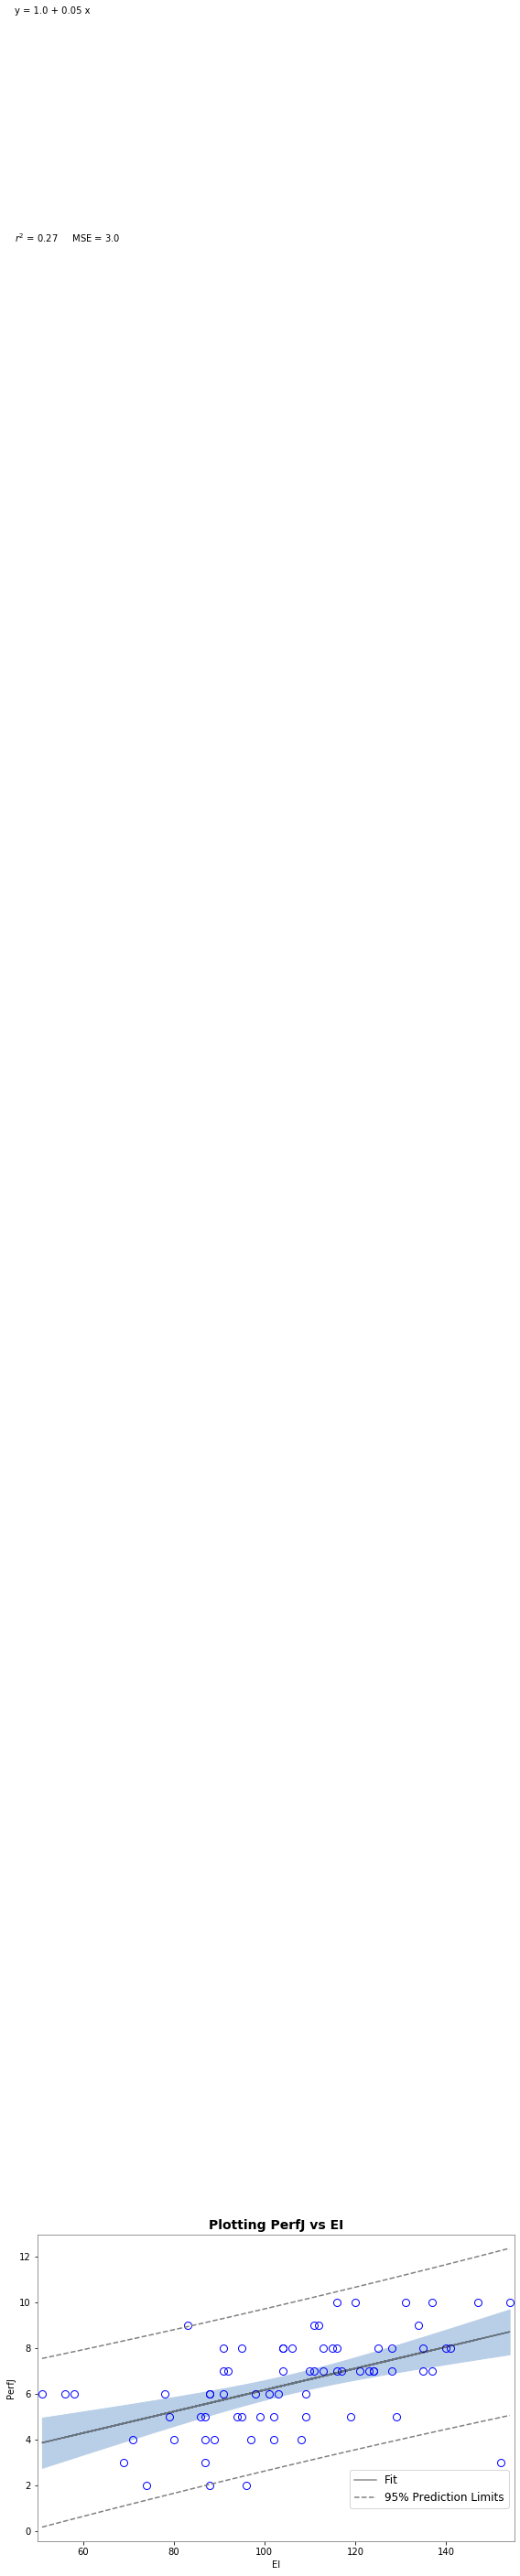

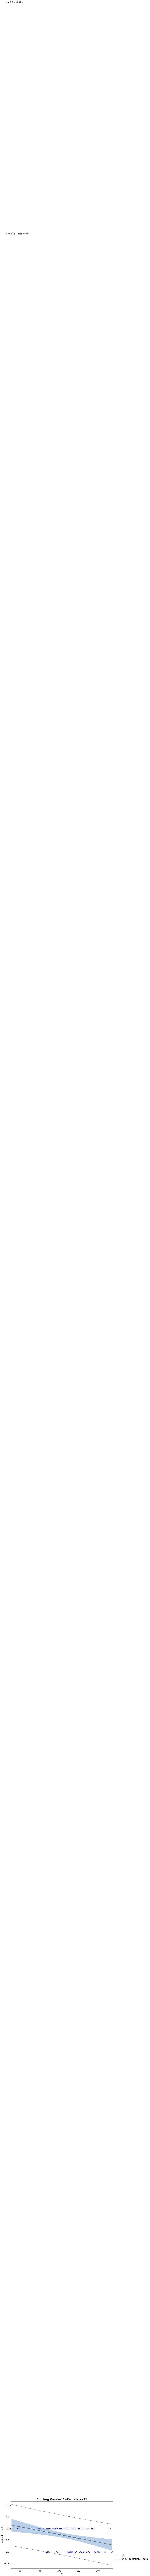

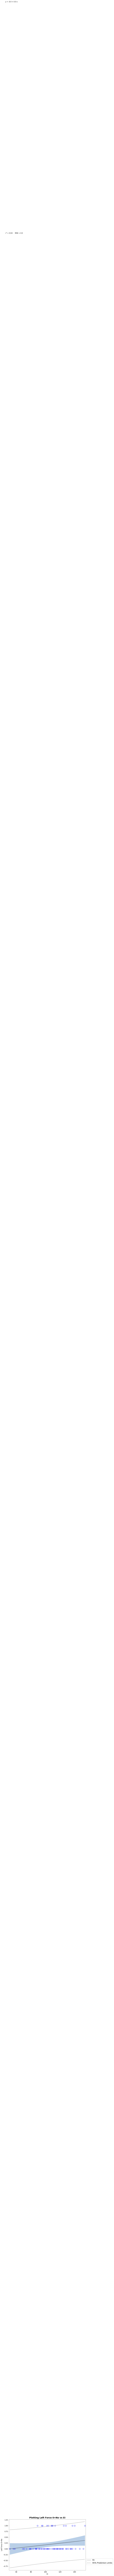

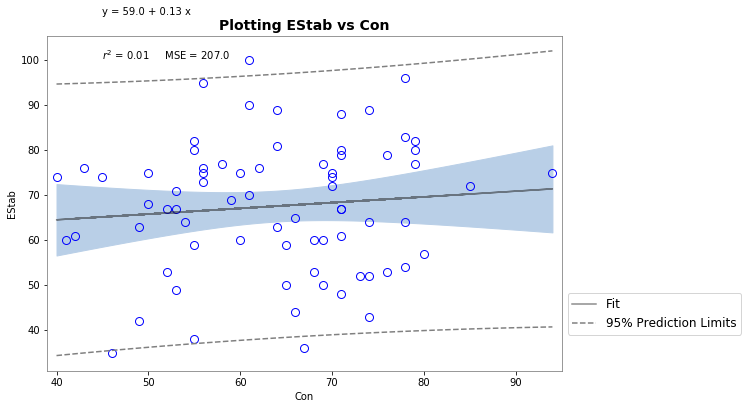

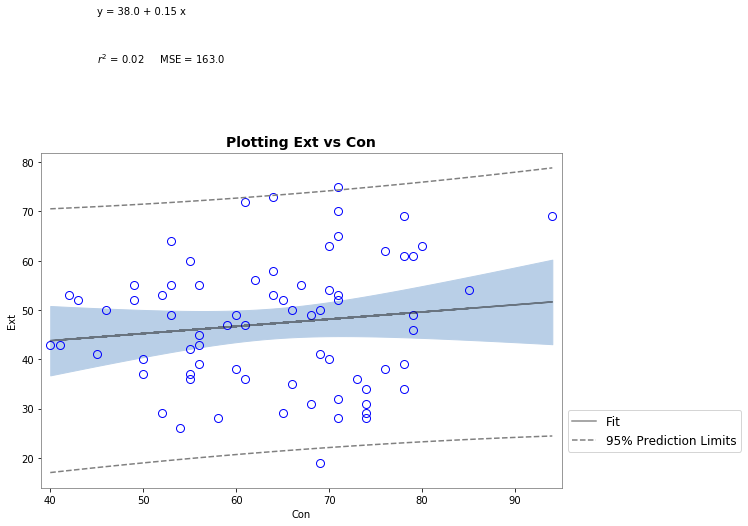

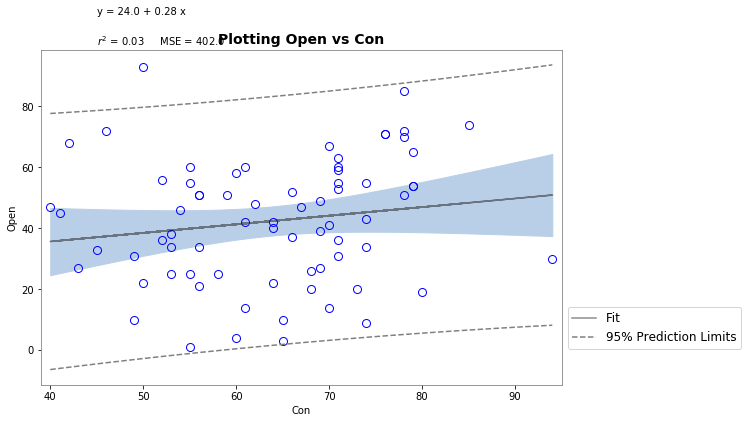

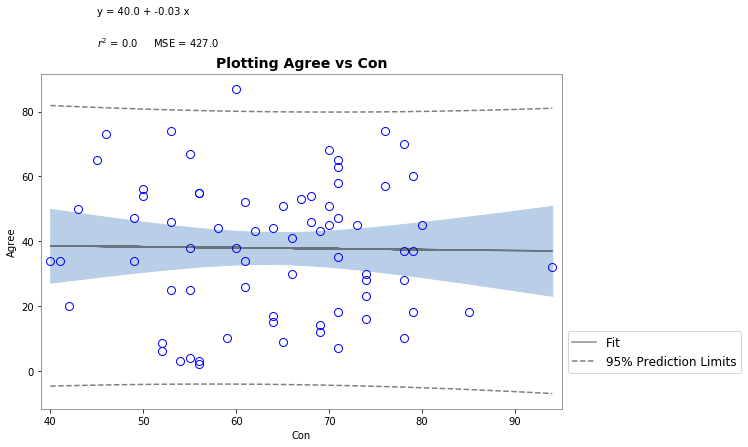

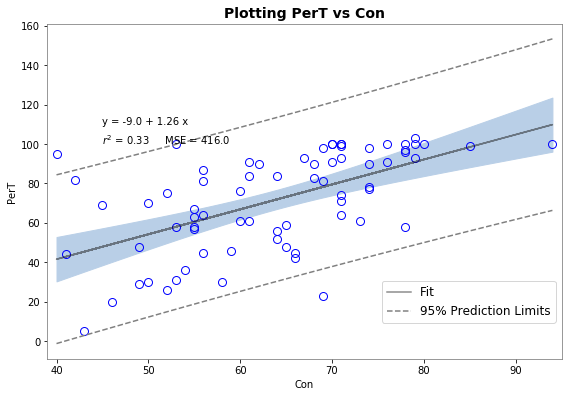

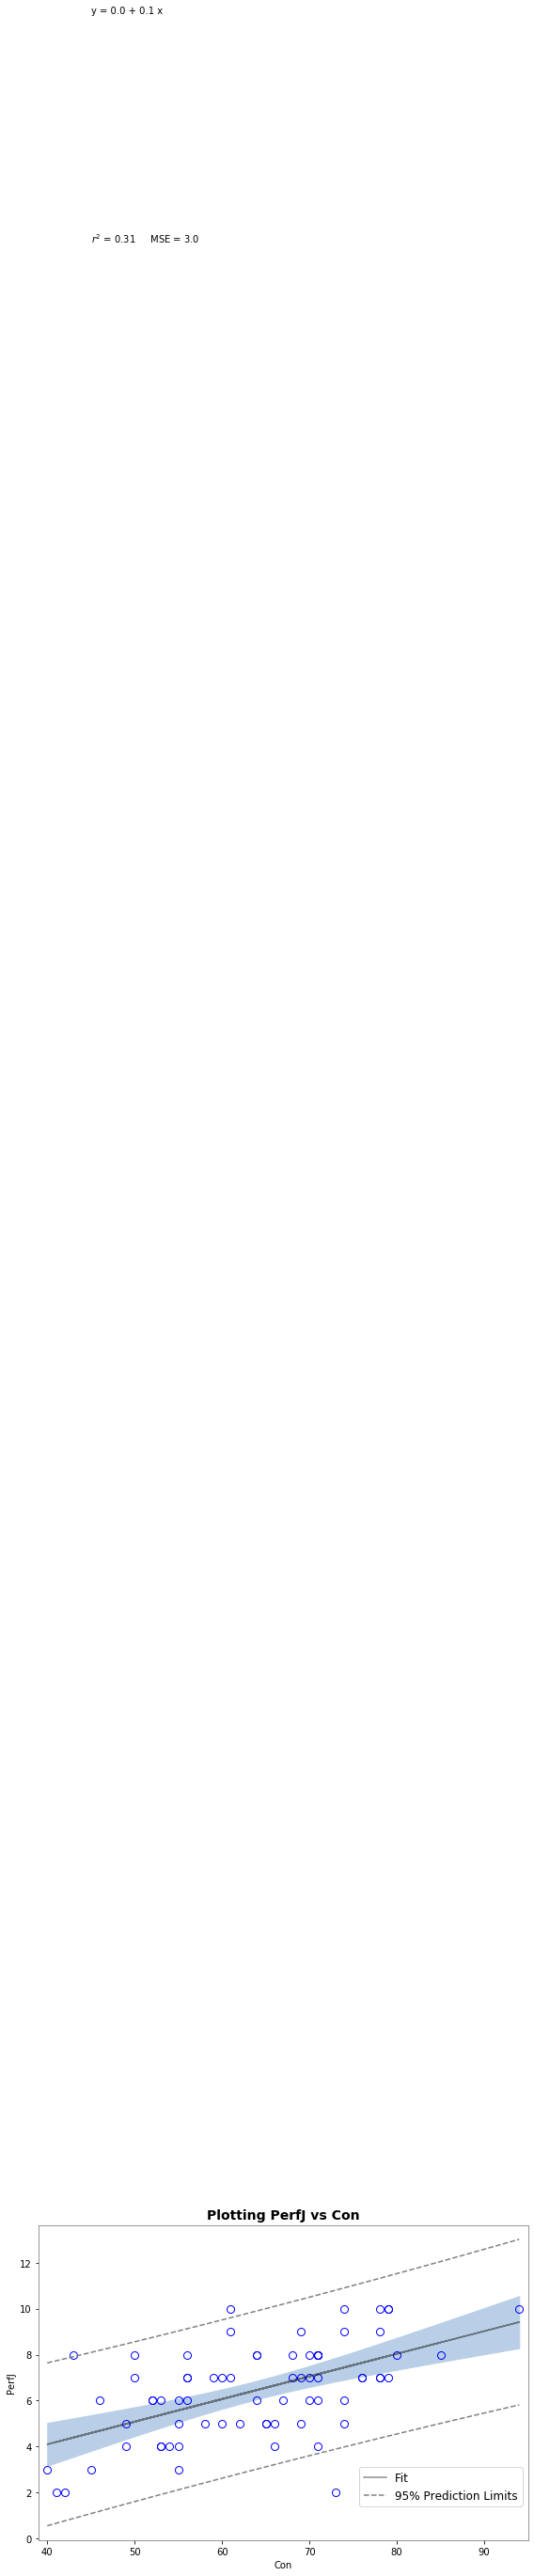

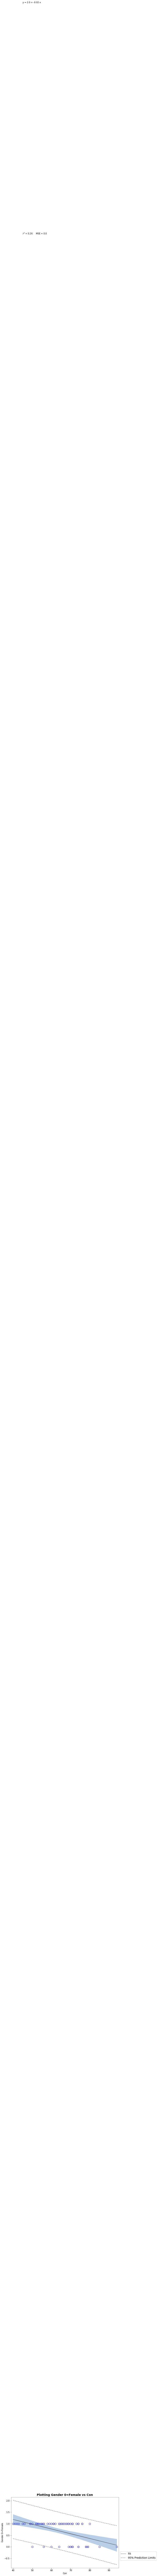

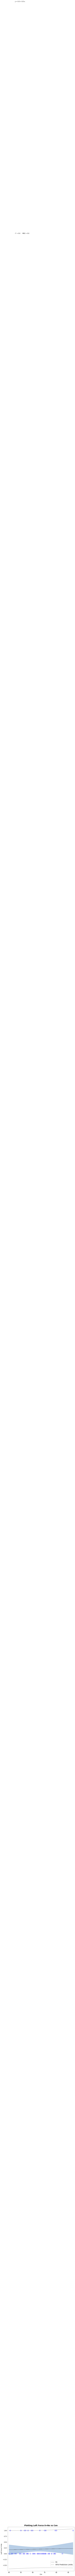

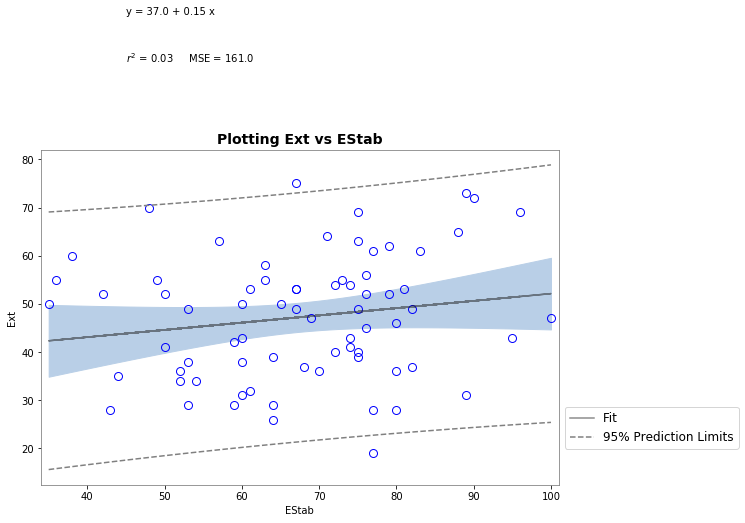

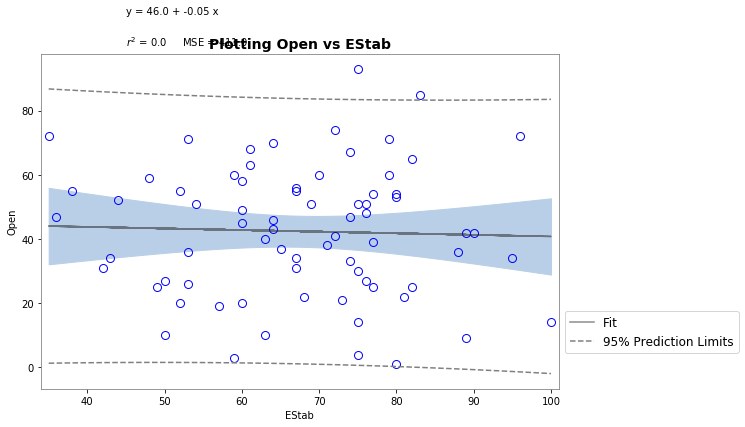

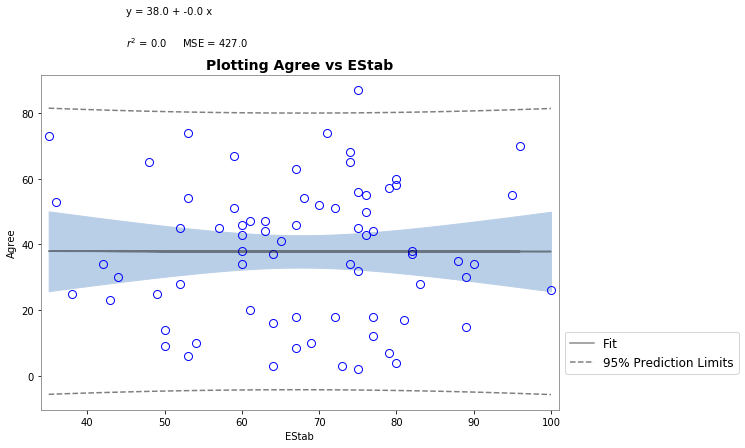

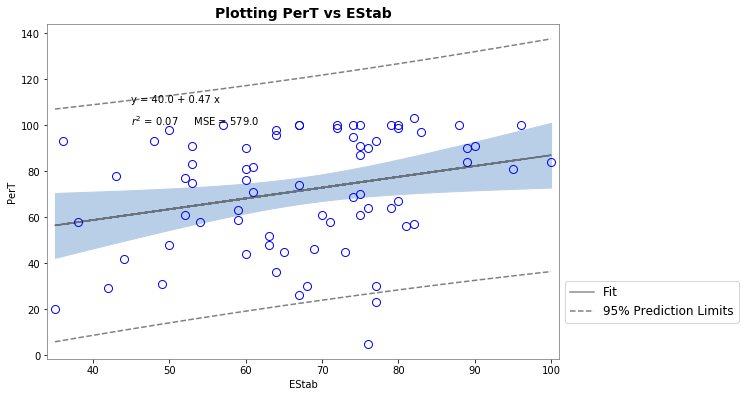

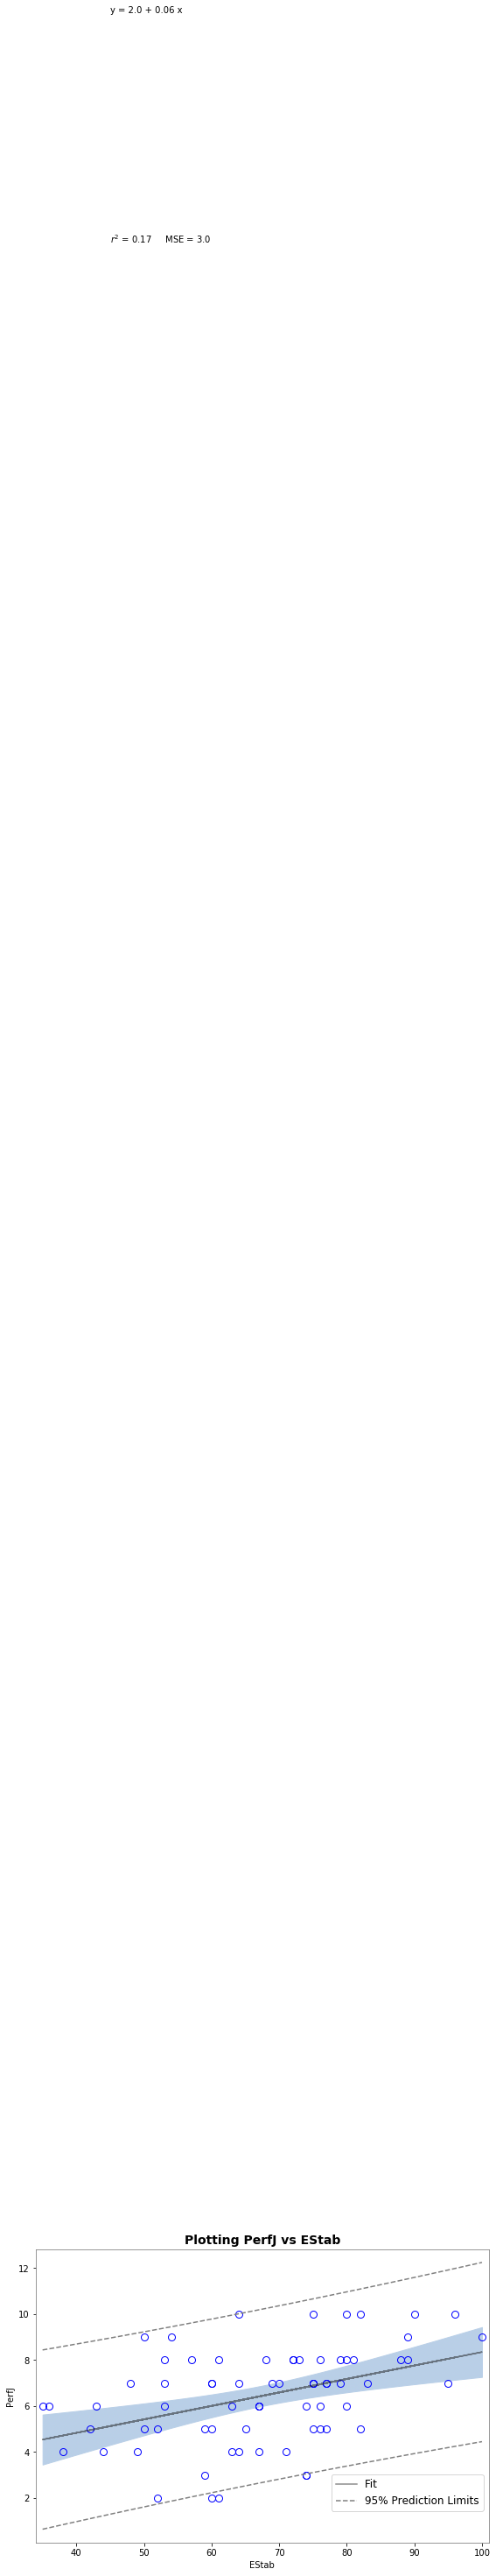

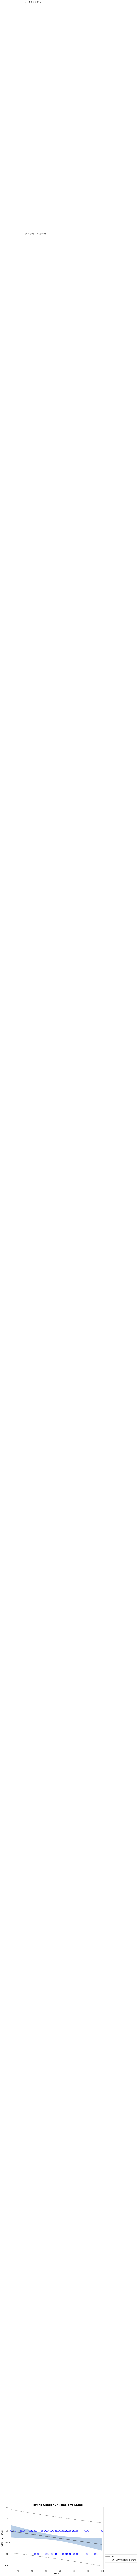

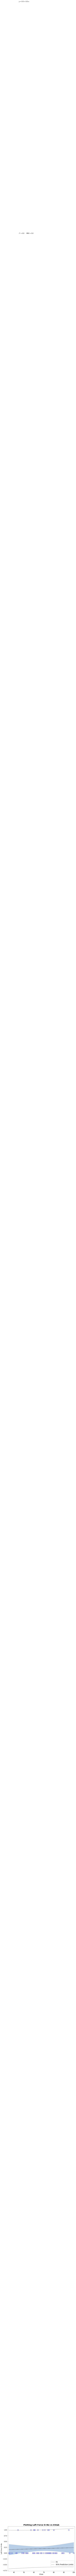

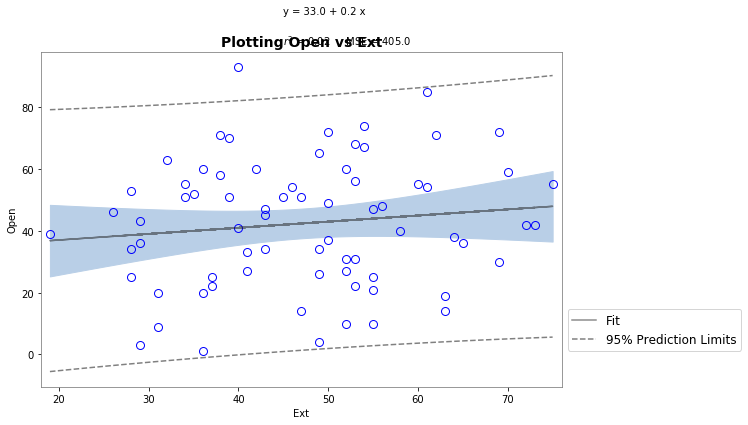

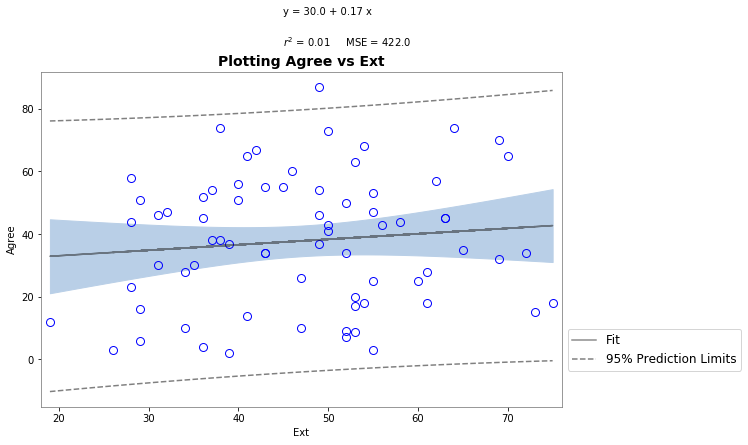

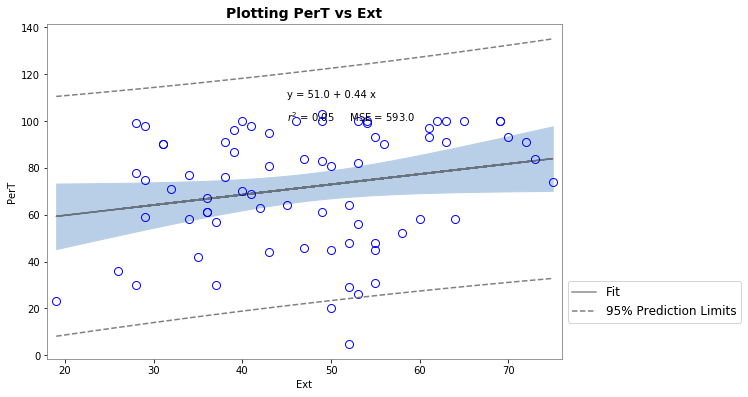

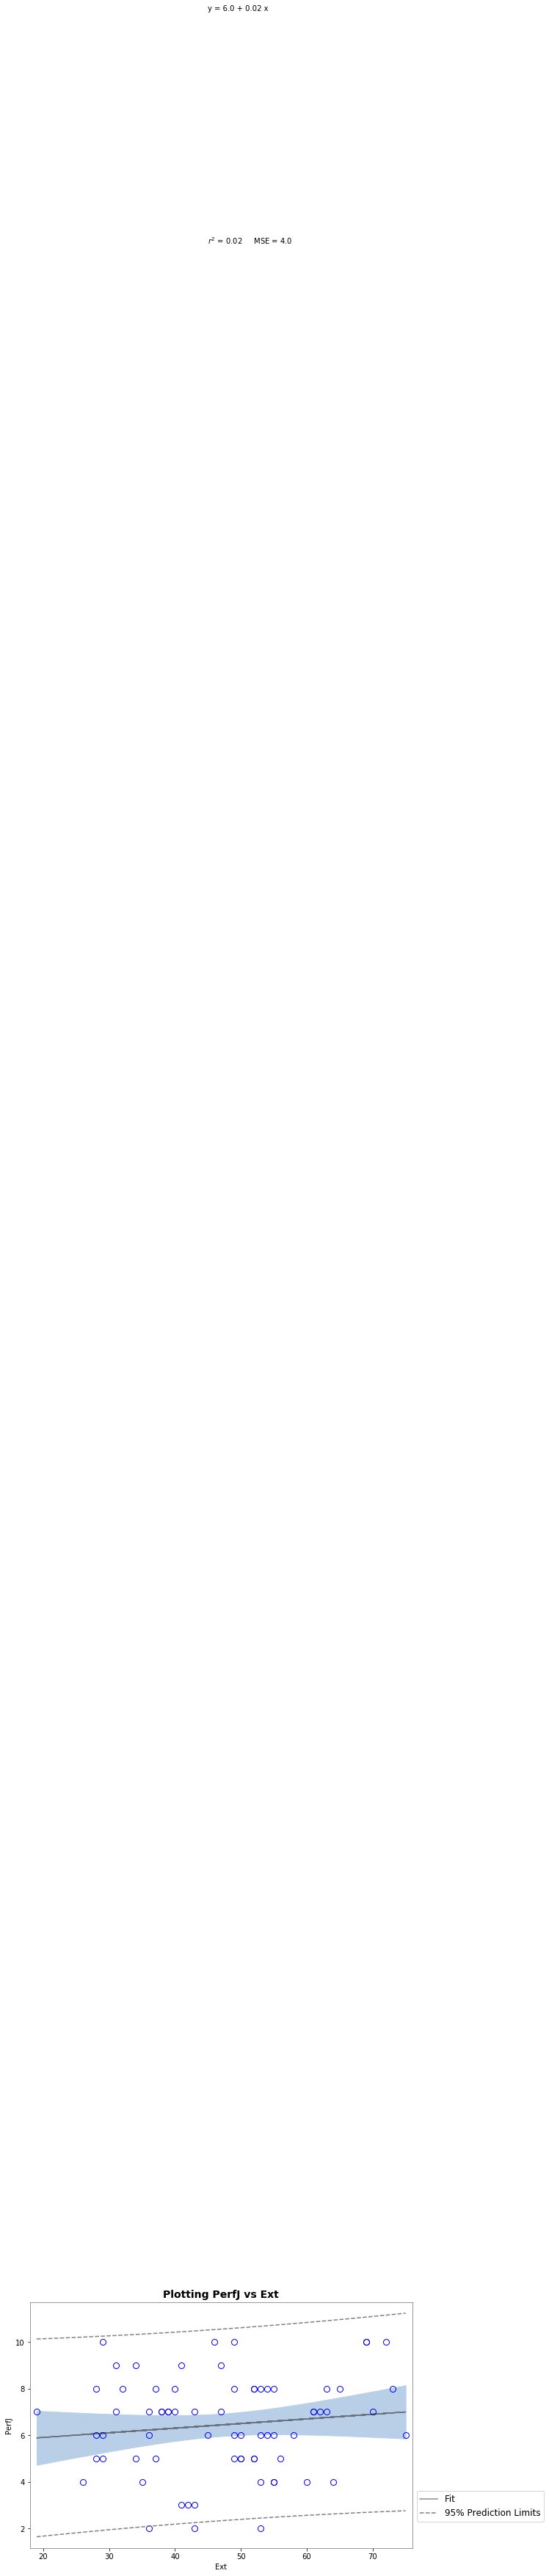

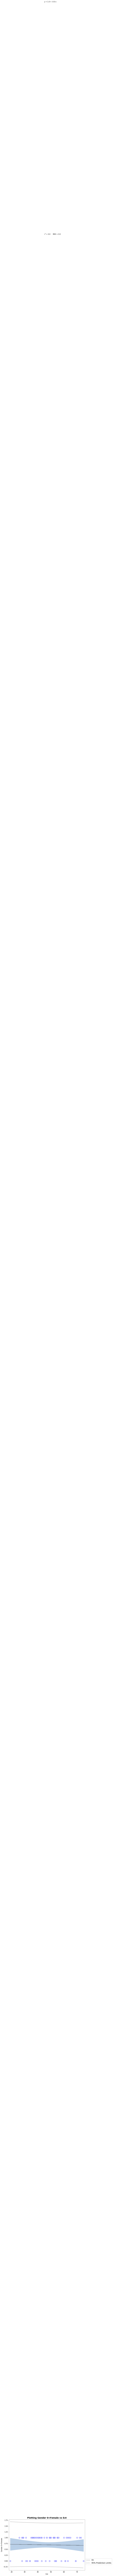

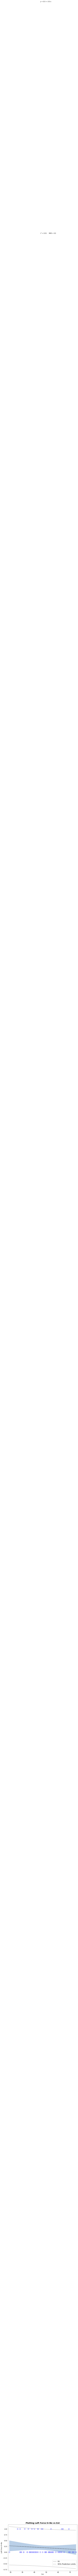

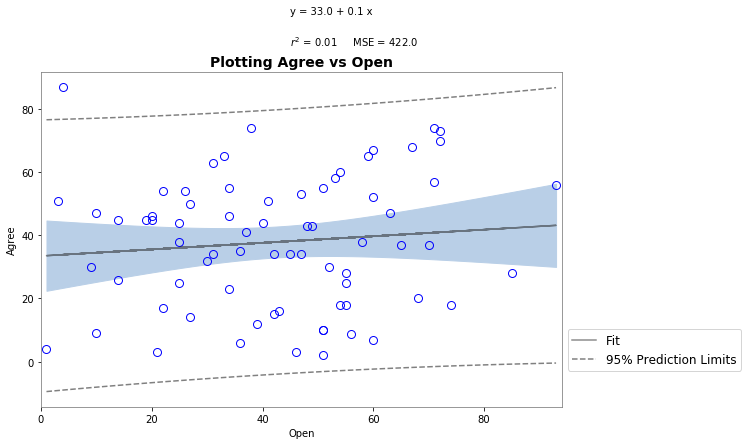

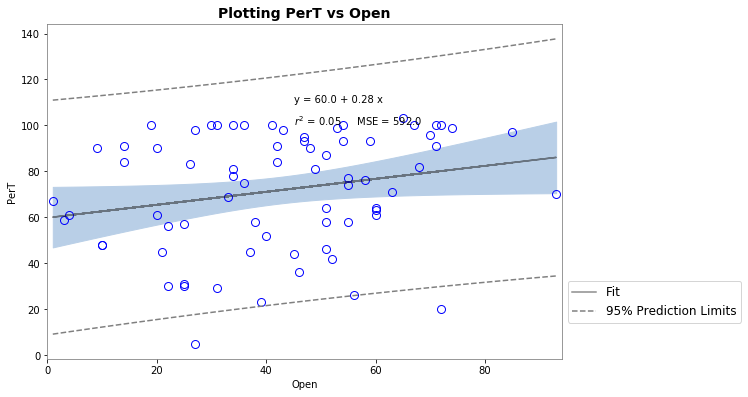

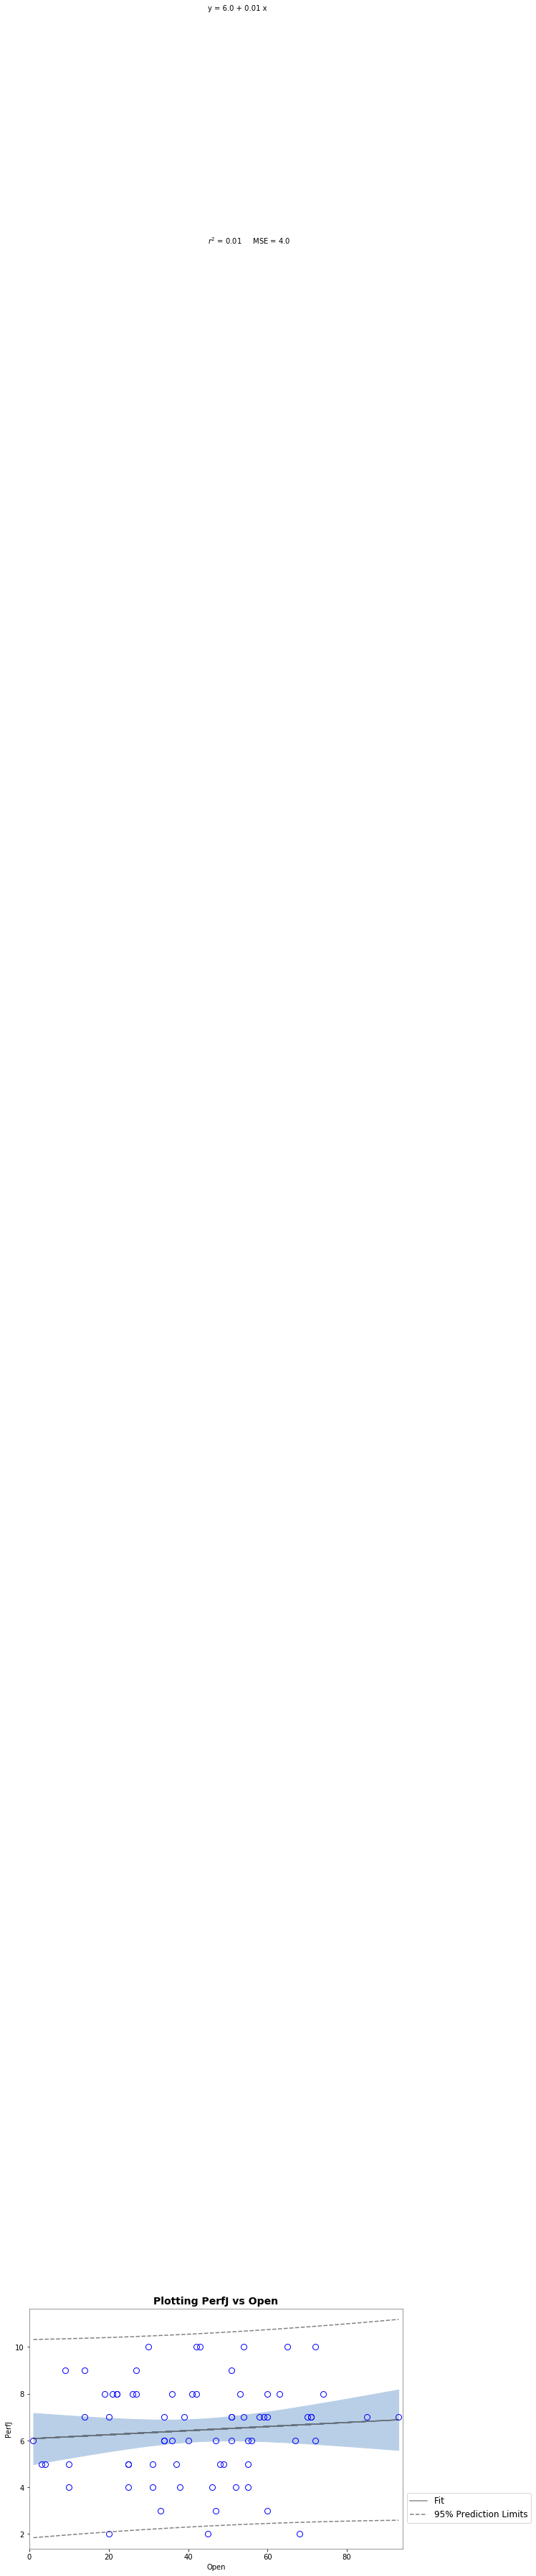

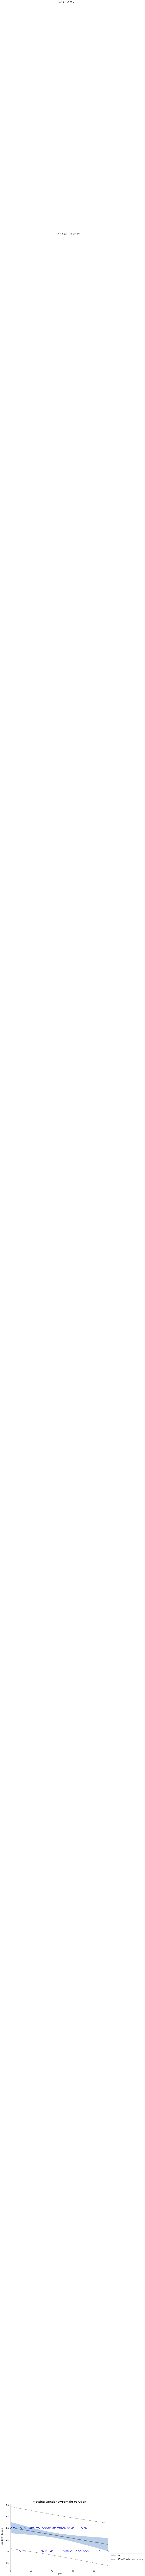

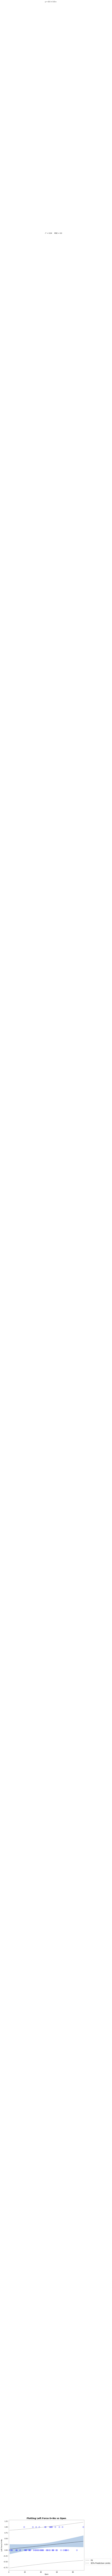

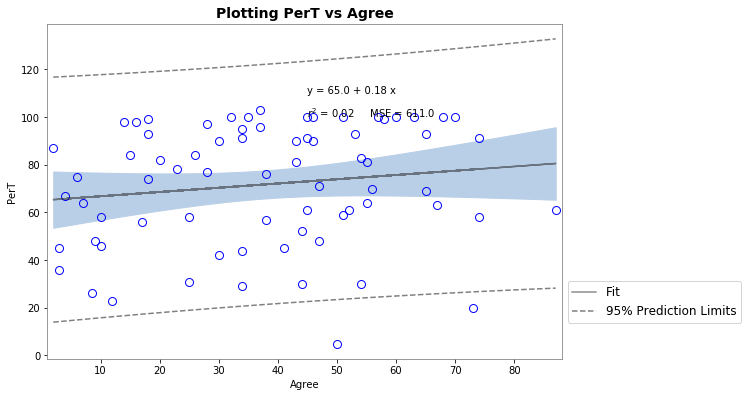

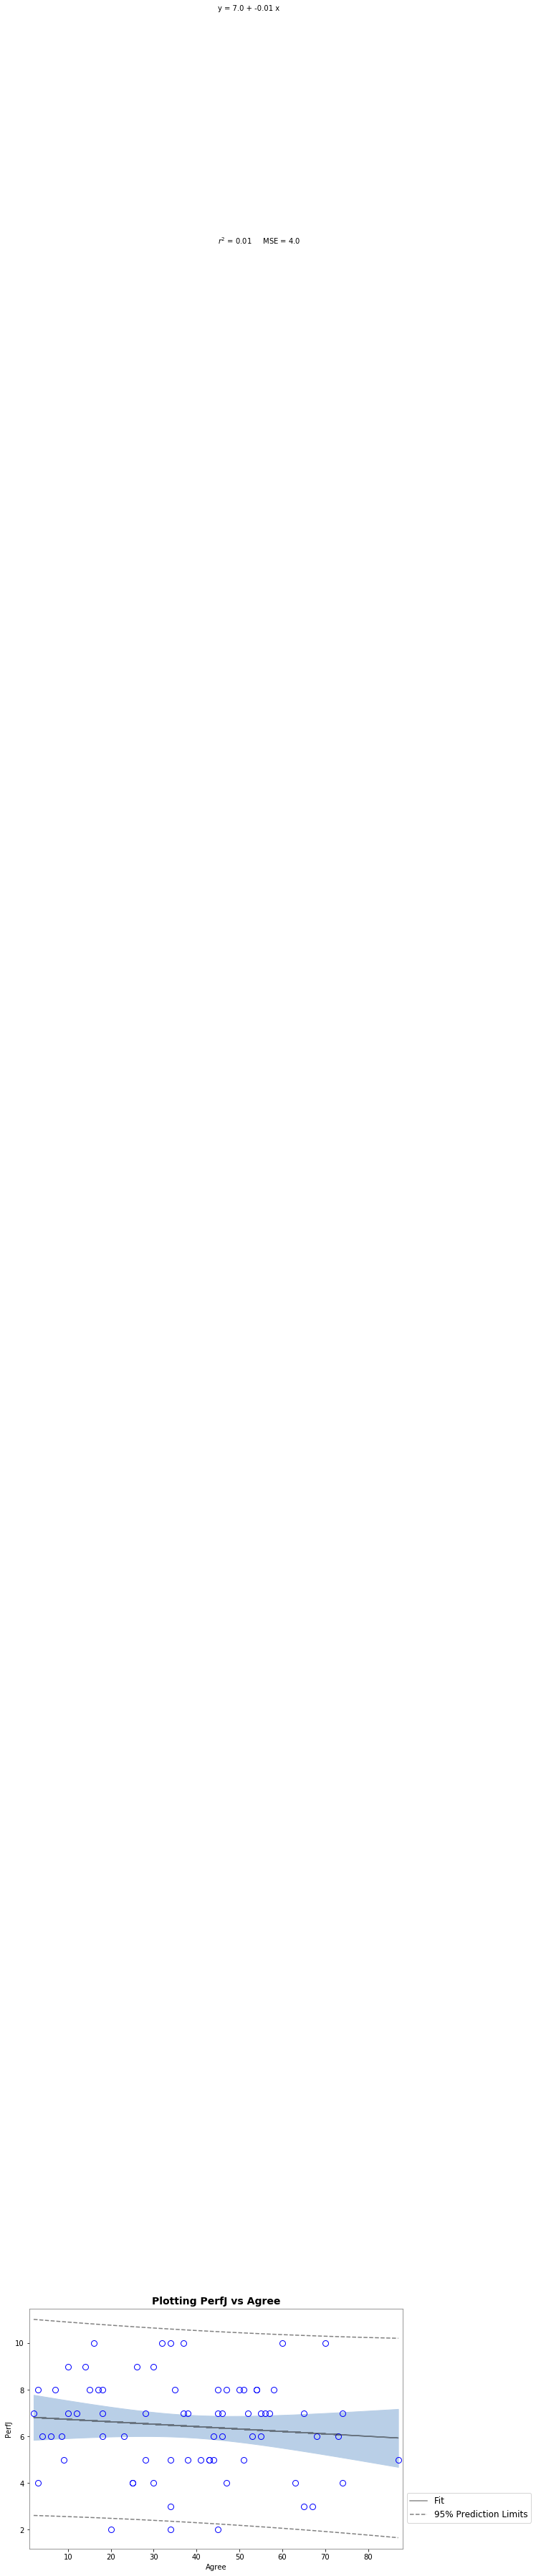

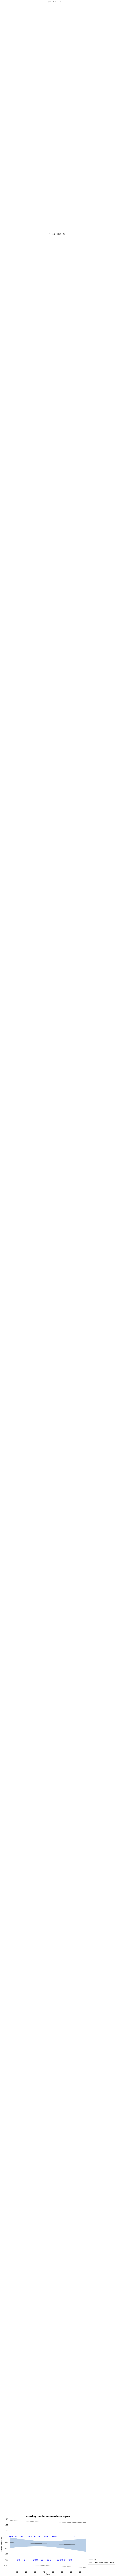

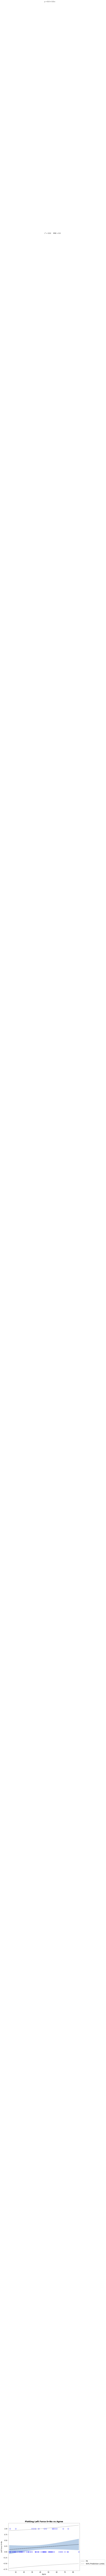

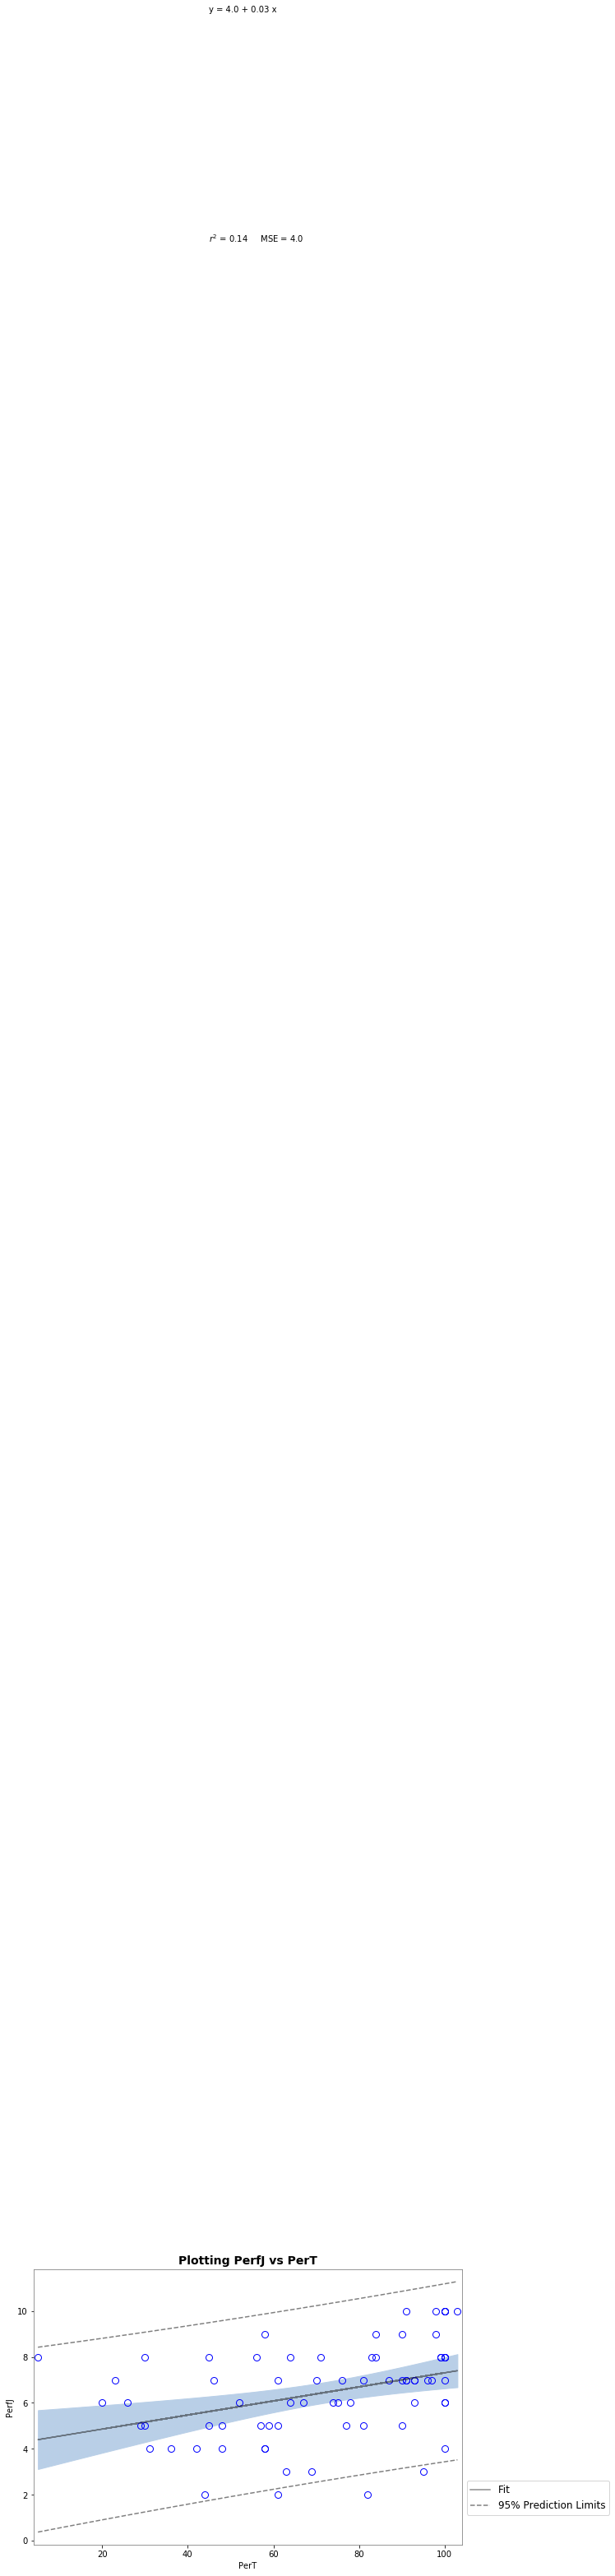

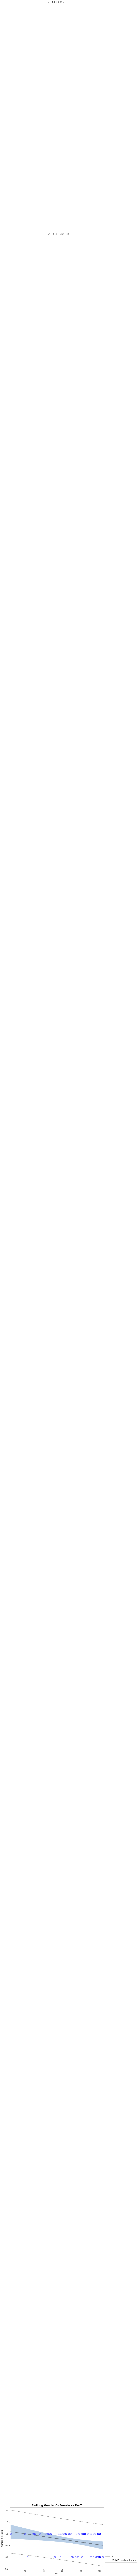

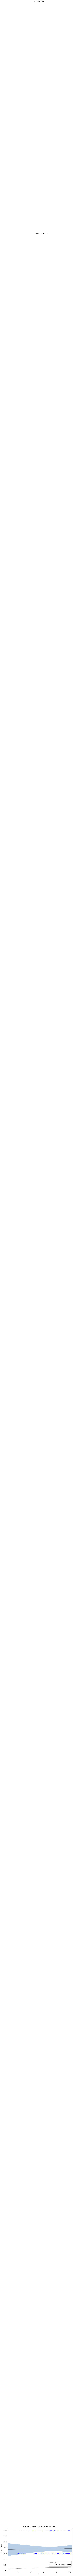

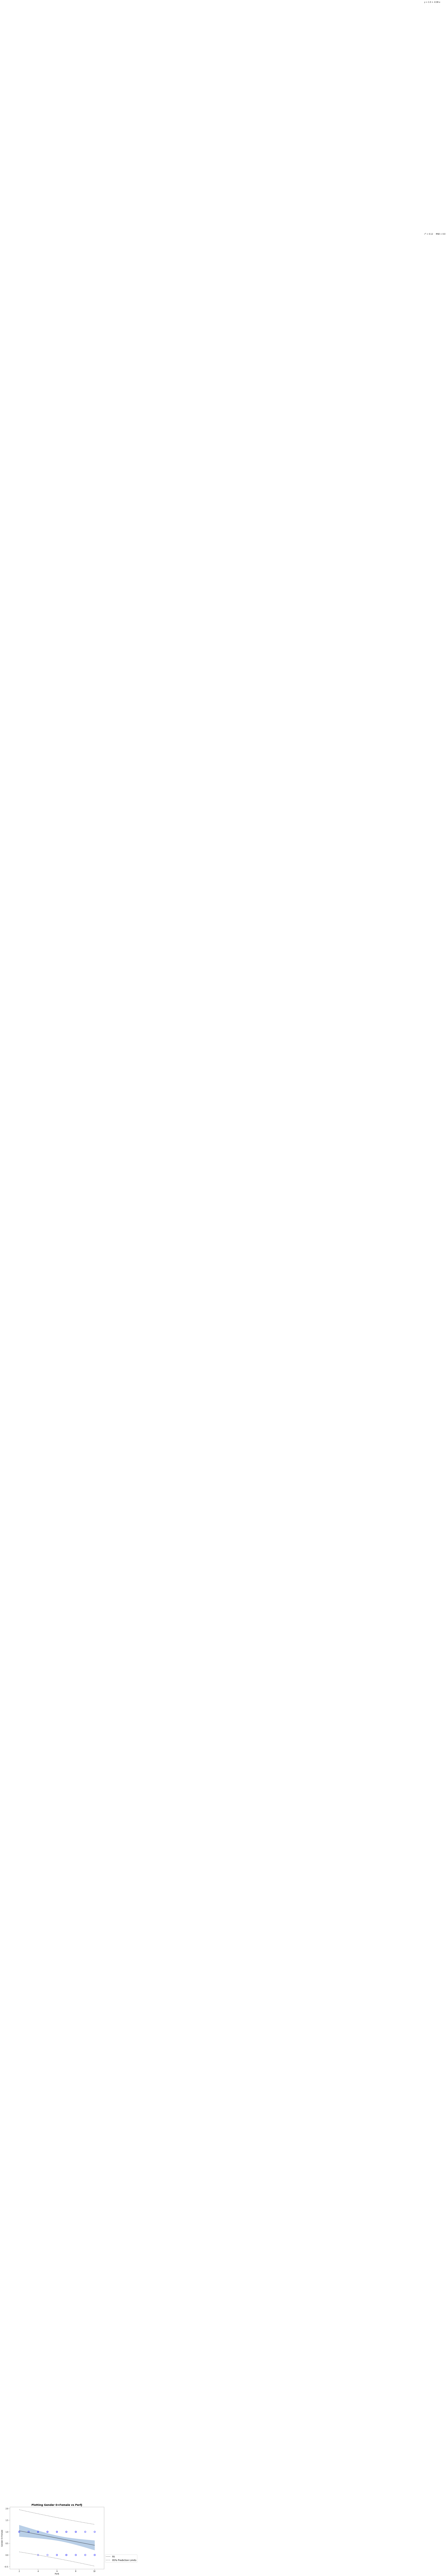

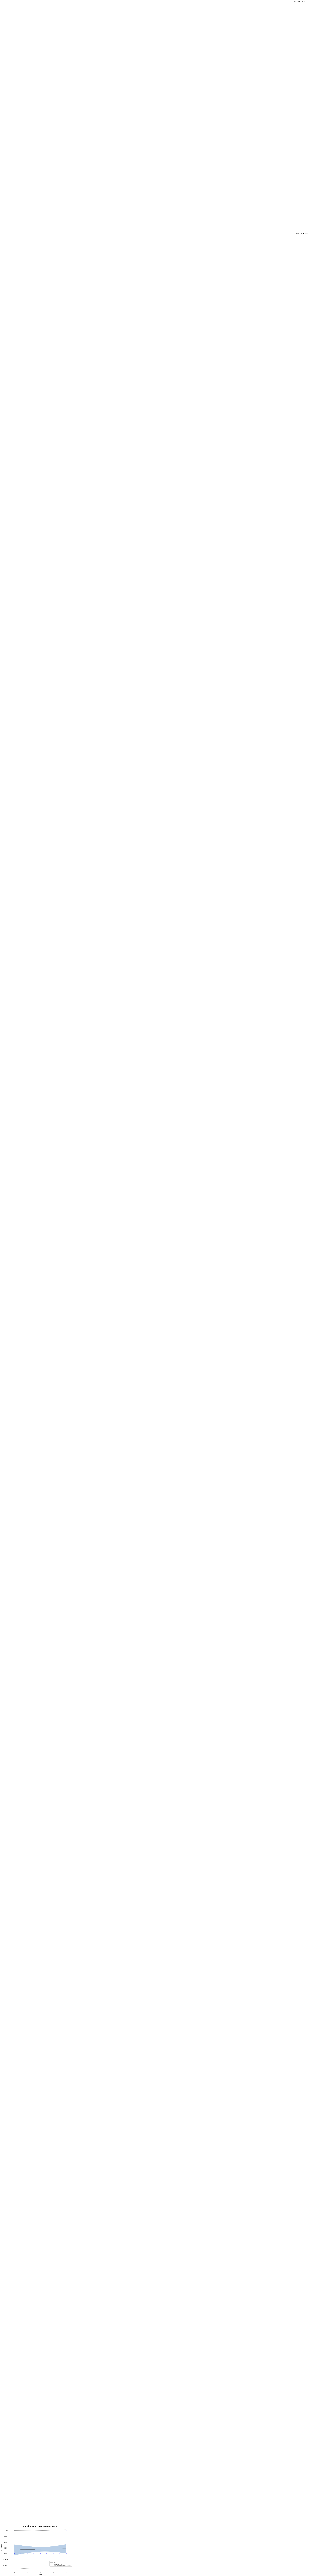

Total  0 combinations


In [11]:
def plotcombinations(data):
    columns = data.columns
    tot = 0
    for i, xlabel in enumerate(columns):
        for j in range(i+1, len(columns)):
            ylabel = columns[j]
            title = "Plotting " + ylabel + " vs " + xlabel
            #print ("len(data[ylabel]):", len(np.ravel(data[ylabel])), "len(data[xlabel]):", len(np.ravel(data[xlabel])))
            #print ("np.ravel(data[ylabel]):", np.ravel(data[ylabel]), "np.ravel(data[xlabel]):", np.ravel(data[xlabel]))
            #print ("data[ylabel]:", data[ylabel], "data[xlabel]:", data[xlabel])
            plot(np.ravel(data[xlabel]), np.ravel(data[ylabel]), title, xlabel, ylabel)
    print ("Total ", tot, "combinations")
plotcombinations(data)